<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/compressiveHolography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressive Holography
## David Brady
## University of Arizona
## June 2022

This notebook considers compressive holographic imaging. As a specific example, we consider an object volume with thickness 1000 $\lambda$. Assume the that the transverse pixel pitch in the volume is 5 $\lambda$, meaning that the maximum lateral spatial frequency is $\frac{1}{10\lambda}$. At this spatial frequency, the longitudinal spatial frequency is $\frac{\sqrt{99}}{10\lambda}$, so the longitudinal bandwidth is $\approx \frac{0.005}{\lambda}$. Nyquist sampling along the longitudinal axis requries planes spaced by $100\lambda$. Accordingly, we consider signals spread over 10 planes and caculate the diffracted field due to objects embedded at these planes. We then attempt to reconstruct the underlying object from the stack of diffraction planes. 

## libraries

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist
import h5py
import tensorflow_io as tfio


In [ ]:
pip install --no-deps tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_io-0.26.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (25.9 MB)


## Angular Spectrum Propagation

In [ ]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
  #zPad=int(np.abs(d*lam)/4)
  #inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('cdouble')
  #inF[int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2),int(inF.shape[0]/2-f.shape[0]/2):int(inF.shape[0]/2+f.shape[0]/2)]=f
  inF=f
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *d*np.sqrt( 1 - u**2 - v**2))))
  return g

#### training and validation images

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11490434/11490434 [==============================] - 0s 0us/step


### Field distribution around objects.

Here we assume that we can reconstruct the field at a set of depths around the true object. In the cell below we visualize the diffracted field around the true object position.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

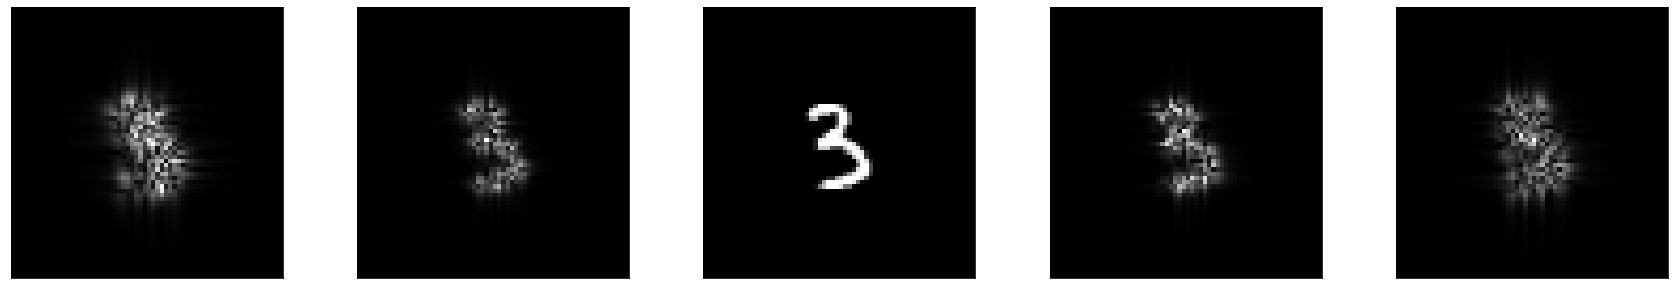

In [ ]:

plt.figure(figsize=(30, 5))
N=64
zplanes=5
lam=.2 # ratio of wavelength to the sampling period
f=np.zeros([N,N]).astype('cdouble')
# insert the mnist image in the center of the field
z=np.random.randint(0,zplanes)
for i in range(0,zplanes):
    ax = plt.subplot(1, zplanes, i+1)
    f[int(N/2-14):int(N/2+14),int(N/2-14):int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[32,:,:]
    q=g(f,(i-z)*100,lam)
    plt.imshow(np.abs(q))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('diffuseObjectDiffraction.pdf')
files.download('diffuseObjectDiffraction.pdf')


## Decompressive Estimation

We assume that the diffracted field is known over the object volume. The goal of decompressive inference is to estimate the 3D object from the field it produces. Here we use the magnitude and real part of the field at 9 planes in the volume to recover the object. 

In [ ]:

N=64
zplanes=5
lam=.2 # ratio of wavelength to the sampling period
f=np.zeros([N,N]).astype('cdouble')
g_test=np.zeros((len(x_test),N,N,zplanes))
f_test=np.zeros((len(x_test),N,N,zplanes))
# generation of test inputs
for pop in range(np.shape(x_test)[0]):
  z=np.random.randint(0,zplanes)
  f_test[pop,int(N/2-14):int(N/2+14),int(N/2-14):int(N/2+14),z]=x_test[pop,:,:]
  for i in range(0, zplanes):
    f[int(N/2-14):int(N/2+14),int(N/2-14):int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[pop,:,:]
    g_test[pop,:,:,i]=np.abs(g(f,(i-z)*100,lam))
with h5py.File('dataset_CompressiveHoloTest.hdf5', 'w') as hf:
    dset_g_test = hf.create_dataset('g_test', data=g_test, shape=g_test.shape, compression='gzip', chunks=True)
    dset_f_train = hf.create_dataset('f_test', data=f_test, shape=f_test.shape, compression='gzip', chunks=True)
del(g_test)
del(f_test)
g_train=np.zeros((len(x_train),N,N,zplanes))
f_train=np.zeros((len(x_train),N,N,zplanes))
# generation of training inputs
for pop in range(np.shape(x_train)[0]):
  z=np.random.randint(0,zplanes)
  f_train[pop,int(N/2-14):int(N/2+14),int(N/2-14):int(N/2+14),z]=x_train[pop,:,:]
  for i in range(0, zplanes):
    f[int(N/2-14):int(N/2+14),int(N/2-14):int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_train[pop,:,:]
    g_train[pop,:,:,i]=np.abs(g(f,(i-z)*100,lam))
with h5py.File('dataset_CompressiveHoloTrain.hdf5', 'w') as hf:
    dset_g_train = hf.create_dataset('g_train', data=g_train, shape=g_train.shape, compression='gzip', chunks=True)
    dset_f_train = hf.create_dataset('f_train', data=f_train, shape=f_train.shape, compression='gzip', chunks=True)
del(g_train)
del(f_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cp *.hdf5 drive/MyDrive/Research/
%cp  drive/MyDrive/Research/*.hdf5 .

In [ ]:
!ls

dataset_CompressiveHoloTest.hdf5   drive
dataset_CompressiveHoloTrain.hdf5  sample_data


In [ ]:

BATCH_SIZE = 128
EPOCHS = 20

# Create an IODataset from a hdf5 file's dataset object  
g_train = tfio.IODataset.from_hdf5("dataset_CompressiveHoloTrain.hdf5",dataset='/g_train')
f_train = tfio.IODataset.from_hdf5("dataset_CompressiveHoloTrain.hdf5",dataset='/f_train')
g_test = tfio.IODataset.from_hdf5("dataset_CompressiveHoloTest.hdf5",dataset='/g_test')
f_test = tfio.IODataset.from_hdf5("dataset_CompressiveHoloTest.hdf5",dataset='/f_test')
 
# Zip together samples and corresponding labels
train = tf.data.Dataset.zip((g_train,f_train)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = tf.data.Dataset.zip((g_test,f_test)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


### Estimation Model

In [ ]:

inputs=keras.Input(shape=(64, 64, 5))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(5, (3, 3), activation="linear", padding="same")(x)


chEstimator = keras.Model(inputs, x)


chEstimator.compile(optimizer='adam', loss='mean_squared_error')
chEstimator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 5)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        4032      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 32, 32, 64)       36928     
 Transpose)                                                

### training

In [ ]:

chEstimator.fit(
   train,
    epochs=20,
    batch_size=128,
    shuffle=True, validation_data=test)

Epoch 1/20


UnimplementedError: ignored